### Code for triangulation in hopes that everything can be automated

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

determine the reference point coordinates (need to add all eventually, and also their respective ID?)

In [2]:
# xyz coordinates of reference points
reference_points = np.array([
    [475287.725, 539899.896, 0], # 1
    [475288.527, 539899.682, 0], # 2
    [475288.898, 539899.235, 0], # 3
    [475290.192, 539899.113, 0], # 4 
    [475292.210, 539900.157, 0], # 5
    [475291.970, 539901.968, 0], # 6
    [475292.783, 539901.734, 0], # 7
    [475292.993, 539901.185, 0], # 8
    [475292.000, 539903.000, 0], # 9 # never used
    [475292.771, 539903.950, 0], # 10
    [475293.945, 539903.572, 0], # 11
    [475294.397, 539903.999, 0], # 12
    [475294.997, 539903.589, 0], # 13
    [475229.425, 539952.654, 0], # 14
    [475231.508, 539951.970, 0], # 15
    [475231.721, 539954.740, 0], # 16
    [475233.636, 539954.306, 0], # 17
    [475235.383, 539956.440, 0], # 18
    [475235.780, 539957.610, 0], # 19
    [475234.816, 539959.693, 0], # 20
    [475236.501, 539958.827, 0], # 21
    [475236.686, 539960.687, 0], # 22
    [475235.559, 539962.693, 0], # 23
    [475238.078, 539964.461, 0], # 24
    [475238.000, 539965.000, 0], # 25 # never used
    [475239.084, 539966.237, 0], # 26
    [475239.649, 539967.106, 0], # 27
    [475237.945, 539968.781, 0], # 28
    [475240.373, 539968.088, 0], # 29
    [475238.303, 539970.257, 0], # 30
    [475239.538, 539970.683, 0], # 31
    ]) 

define a function that will trilaterate for me (need to use least_squares in order to account for field data and triangles that do not coincide)

In [3]:
def trilaterate(p1, p2, p3, r1, r2, r3):
    # need to define an error function that calculates the difference between
    # the measured distances and the distances from an estimated position
    def error_func(pos, p1, p2, p3, r1, r2, r3):
        return [
            np.linalg.norm(pos - p1) - r1,  # difference for the first point
            np.linalg.norm(pos - p2) - r2,  # difference for the second point
            np.linalg.norm(pos - p3) - r3   # difference for the third point
        ]
    # initial guess for the position: the centroid of the three reference points
    initial_guess = np.mean([p1, p2, p3], axis=0)
    # use least squares optimization to minimize the error function
    result = least_squares(error_func, initial_guess, args=(p1, p2, p3, r1, r2, r3))

    # this is to compute the uncertainty of the estimated position
    J = result.jac # approximate the Jacobian at the solution
    cov = np.linalg.pinv(J.T.dot(J)) # covariance matrix
    std_devs = np.sqrt(np.diag(cov)) # standard deviations
    radius_of_uncertainty = np.max(std_devs) # the maximum standard deviation is the radius
    error_metric = np.sum(np.abs(error_func(result.x, p1, p2, p3, r1, r2, r3)))

    return result.x[0], result.x[1], error_metric, radius_of_uncertainty

read the distances to each ref point (each survey)

In [4]:
survey = pd.read_csv('Surveys_for_code/test.csv', na_values='-')  
# convert all columns that pandas recognizes as numeric to floats
survey = survey.apply(lambda x: x.astype(float) if x.dtype.kind in 'biufc' else x)
# prepare to store the results
results = []

compute the coordinates of my particle IDs

In [5]:
for idx, row in survey.iterrows():
    particle_id = row['ParticleID'] # extract the particle ID for the current row
    ref_idx_a, ref_idx_b, ref_idx_c = int(row['Ref1']), int(row['Ref2']), int(row['Ref3'])
    r1, r2, r3 = row['Dist1'], row['Dist2'], row['Dist3'] # extract the distances from the particle to each of the reference points
    
    if pd.isna(r1) or pd.isna(r2) or pd.isna(r3):
        x, y, error_metric, radius_of_uncertainty = np.nan, np.nan, np.nan, np.nan  # assign NaN if any value is NaN
    else:
    # get the (x, y) coordinates of each reference point from the reference_points array
    # subtract 1 from the indices since Python arrays are zero-indexed
        p1 = reference_points[ref_idx_a - 1].astype(float)
        p2 = reference_points[ref_idx_b - 1].astype(float)
        p3 = reference_points[ref_idx_c - 1].astype(float)
        x, y, error_metric, radius_of_uncertainty = trilaterate(p1, p2, p3, r1, r2, r3)
    # append the particle ID and its calculated coordinates to the results list
    #print('The coordinates of particle {} are: ({:.3f}, {:.3f})'.format(particle_id, x, y))
    results.append((particle_id, x, y, error_metric, radius_of_uncertainty))

# convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=['ParticleID', 'X', 'Y','ErrorMetric', 'RadiusOfUncertainty'])
# save the results to a CSV file
results_df.to_csv('particle_positions.csv', index=False)

plotting results

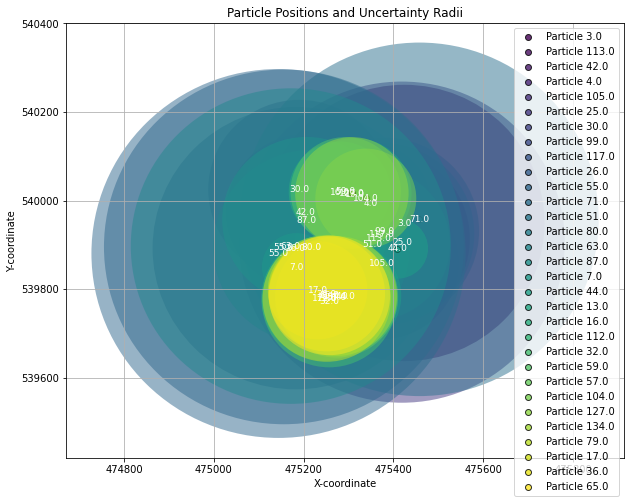

In [14]:
cleaned_df = results_df.dropna(subset=['X', 'Y', 'RadiusOfUncertainty'])
cleaned_df = cleaned_df[np.isfinite(cleaned_df['X']) & np.isfinite(cleaned_df['Y']) & np.isfinite(cleaned_df['RadiusOfUncertainty'])]

plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(cleaned_df['ParticleID'].unique())))

for i, pid in enumerate(cleaned_df['ParticleID'].unique()):
    data_pid = cleaned_df[cleaned_df['ParticleID'] == pid]
    plt.scatter(data_pid['X'], data_pid['Y'], color=colors[i], label=f'Particle {pid}', alpha=0.8, edgecolor='black')
    # draw a circle to represent the radius of uncertainty
    for x, y, radius in zip(data_pid['X'], data_pid['Y'], data_pid['RadiusOfUncertainty']):
        circle = plt.Circle((x, y), radius, color=colors[i], alpha=0.5, linewidth=0, fill=True)
        plt.gca().add_patch(circle)
        # annotate the plot with the Particle ID
        plt.text(x, y, str(pid), fontsize=9, ha='center', va='center', color='white')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Particle Positions and Uncertainty Radii')
plt.legend()
plt.grid(True)
plt.show()